In [88]:
import random
from typing import Tuple, List, Dict
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [89]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: mps


In [90]:
import os

BASE_DIR = os.path.expanduser("~/Desktop/Resnet-Mac/Data")  # match where your files actually are
CSV_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")
IMAGES_DIRS = [
    os.path.join(BASE_DIR, "HAM10000_images_part_1"),
    os.path.join(BASE_DIR, "HAM10000_images_part_2")
]

# Check file exists
print(os.path.exists(CSV_PATH))  # should be True

# Pass explicitly to your function
train_df, val_df, test_df = prepare_data(csv_path=CSV_PATH)

True
Samples -> train: 7010, val: 1002, test: 2003


In [91]:
# import pandas as pd
# df = pd.read_csv("/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_metadata.csv")
# df.head()

In [92]:
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
IMG_SIZE = 224        # classification image size
SEG_SIZE = 256        # segmentation input size
BATCH_SIZE = 8
SEG_EPOCHS = 12
CLS_EPOCHS = 12
LEARNING_RATE = 1e-4

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
CLASS_MAP = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}
CLASSES = list(CLASS_MAP.keys())
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {k: i for i, k in enumerate(CLASSES)}
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}

In [93]:
def read_image(path, color=True):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def ensure_rgb(img):
    # PIL -> numpy or cv2 ensures shape HWC
    if len(img.shape) == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[2] == 4:
        img = img[..., :3]
    return img

import glob
# Removed find_image_path as we will pre-build a mapping

In [94]:
class HAMSegmentationDataset(Dataset):
    """
    For segmentation: returns image and mask.
    If masks are not present, creates rough masks using Otsu thresholding as fallback.
    Requires metadata CSV with image_id or lesion_id and filename.
    """
    def __init__(self, df, image_path_map, transforms=None, target_size=SEG_SIZE):
        self.df = df.reset_index(drop=True)
        self.image_path_map = image_path_map # Use the pre-built map
        self.transforms = transforms
        self.target_size = target_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id'] if 'image_id' in row else row['image_id']
        img_path = self.image_path_map.get(image_id + ".jpg") # Get path from map

        if img_path is None:
            print(f"Warning: Image {image_id}.jpg not found in map. Skipping.")
            # fallback: sample another random item to avoid crashing the dataloader
            new_idx = random.randint(0, len(self.df) - 1)
            return self.__getitem__(new_idx)

        img = read_image(img_path)
        img = ensure_rgb(img)
        # segmentation mask: if user has supplied masks, load them.
        # HAM10000 does not include masks by default; we will make a weak mask via simple preprocessing.
        mask = create_weak_mask(img)

        # Ensure image and mask are resized to target_size before transformations
        img = cv2.resize(img, (self.target_size, self.target_size))
        mask = cv2.resize(mask, (self.target_size, self.target_size), interpolation=cv2.INTER_NEAREST)


        # Albumentations expects HWC numpy arrays
        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()
        else:
            image = TF.to_tensor(Image.fromarray(img)) # Removed resize here
            mask = TF.to_tensor(Image.fromarray(mask)).float() # Removed resize here

        return image, mask

def create_weak_mask(img: np.ndarray) -> np.ndarray:
    """
    Create a simple mask for lesions using color space heuristics + Otsu.
    This is not perfect but often good enough to train the segmentation model if ground truths are not available.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Otsu threshold
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # morphological ops
    kernel = np.ones((5,5), np.uint8)
    opening = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel, iterations=1)
    # fill holes
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(opening)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest], -1, 255, -1)
    mask = mask // 255
    return mask.astype(np.uint8)

In [95]:
class HAMClassificationDataset(Dataset):
    """
    For classification: uses H x W images (cropped using segmentation mask optionally)
    Expects 'image_id' and 'dx' columns in dataframe (dx = lesion label like 'nv', 'mel', etc.)
    """
    def __init__(self, df, image_path_map, transforms=None, seg_model=None, seg_size=SEG_SIZE, cls_size=IMG_SIZE, use_segmentation=True):
        self.df = df.reset_index(drop=True)
        self.image_path_map = image_path_map # Use the pre-built map
        self.transforms = transforms
        self.seg_model = seg_model
        self.seg_size = seg_size
        self.cls_size = cls_size
        self.use_segmentation = use_segmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        label = row['dx']
        img_path = self.image_path_map.get(image_id + ".jpg") # Get path from map

        if img_path is None:
            # fallback: sample another random item to avoid crashing the dataloader
            new_idx = random.randint(0, len(self.df) - 1)
            print(f"Warning: Image {image_id}.jpg not found in map. Skipping.")
            return self.__getitem__(new_idx)

        img = read_image(img_path)
        img = ensure_rgb(img)

        # optional segmentation-guided crop
        if self.use_segmentation and self.seg_model is not None:
            # prepare seg input (resize -> normalize -> to tensor)
            seg_input = cv2.resize(img, (self.seg_size, self.seg_size))
            seg_input = seg_input.astype(np.float32) / 255.0
            seg_input = np.transpose(seg_input, (2, 0, 1))
            seg_input = torch.tensor(seg_input).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                pred_mask = self.seg_model(seg_input)[0]             # logits
                pred_mask = torch.sigmoid(pred_mask).cpu().numpy().squeeze()
                bmask = (pred_mask > 0.5).astype(np.uint8)
                # resize mask back to original image size
                bmask = cv2.resize(bmask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            x, y, w, h = mask_to_bbox(bmask)
            if w > 0 and h > 0:
                pad = int(0.15 * max(w, h))
                x1 = max(0, x - pad); y1 = max(0, y - pad)
                x2 = min(img.shape[1], x + w + pad); y2 = min(img.shape[0], y + h + pad)
                crop = img[y1:y2, x1:x2]
            else:
                crop = img
        else:
            crop = img

        # Ensure we always resize the crop to a fixed classification size
        crop = cv2.resize(crop, (self.cls_size, self.cls_size), interpolation=cv2.INTER_LINEAR)

        if self.transforms:
            augmented = self.transforms(image=crop)
            image = augmented['image']
        else:
            image = TF.to_tensor(Image.fromarray(crop))

        return image, CLASS_TO_IDX[label]

def mask_to_bbox(mask: np.ndarray) -> Tuple[int,int,int,int]:
    ys, xs = np.where(mask>0)
    if len(xs)==0 or len(ys)==0:
        return 0,0,0,0
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    return x1, y1, x2-x1, y2-y1

In [96]:
class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        backbone = models.resnet50(pretrained=pretrained)
        # extract blocks
        self.initial = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )  # out /4
        self.layer1 = backbone.layer1  # out /4
        self.layer2 = backbone.layer2  # out /8
        self.layer3 = backbone.layer3  # out /16
        self.layer4 = backbone.layer4  # out /32

    def forward(self, x):
        x0 = self.initial(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return x0, x1, x2, x3, x4

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip=None): # Added skip=None for consistency
        if skip is not None:
            # Use explicit size (H, W) from skip for upsampling
            target_h, target_w = skip.size(2), skip.size(3)
            x = F.interpolate(x, size=(target_h, target_w), mode='bilinear', align_corners=False)
            # safety check (useful while debugging)
            assert x.size(2) == skip.size(2) and x.size(3) == skip.size(3), \
                f"Spatial mismatch after upsample: x={x.size()}, skip={skip.size()}"
            x = torch.cat([x, skip], dim=1)
        else:
            # If no skip, assume simple upsampling by 2
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.conv(x)
        return x

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super().__init__()
        self.encoder = ResNet50Encoder(pretrained=pretrained)
        # the channel dims from ResNet50
        chs = [64, 256, 512, 1024, 2048]
        # Decoder blocks with correct input and output channels
        # The input to decoder4 is x4 (2048) and skip x3 (1024) -> 2048 + 1024 = 3072
        self.decoder4 = DecoderBlock(chs[4] + chs[3], 512) # input 3072, output 512, upsamples x4 to match x3
        # input to decoder3 is output of decoder4 (512) and skip x2 (512) -> 512 + 512 = 1024
        self.decoder3 = DecoderBlock(512 + chs[2], 256) # input 1024, output 256, upsamples decoder4 output to match x2
        # input to decoder2 is output of decoder3 (256) and skip x1 (256) -> 256 + 256 = 512
        self.decoder2 = DecoderBlock(256 + chs[1], 128) # input 512, output 128, upsamples decoder3 output to match x1
        # input to decoder1 is output of decoder2 (128) and skip x0 (64) -> 128 + 64 = 192
        self.decoder1 = DecoderBlock(128 + chs[0], 64) # input 192, output 64, upsamples decoder2 output to match x0
        # The initial block output x0 is 1/4 of the original size.
        # To get back to the original size, we need two more upsampling steps (1/4 -> 1/2 -> 1)
        # input to decoder0 is output of decoder1 (64), no skip -> 64
        self.decoder0 = DecoderBlock(64, 32) # input 64, output 32, upsamples decoder1 output by 2 (1/4 -> 1/2)
        # input to decoder_out is output of decoder0 (32), no skip -> 32
        self.decoder_out = DecoderBlock(32, 16) # input 32, output 16, upsamples decoder0 output by 2 (1/2 -> 1)

        self.final_conv = nn.Conv2d(16, n_classes, kernel_size=1) # input 16, output n_classes

    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encoder(x)
        d4 = self.decoder4(x4, x3)
        d3 = self.decoder3(d4, x2)
        d2 = self.decoder2(d3, x1)
        d1 = self.decoder1(d2, x0)
        d0 = self.decoder0(d1) # No skip connection here
        d_out = self.decoder_out(d0) # No skip connection here
        out = self.final_conv(d_out)
        return out  # logits

In [97]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.shared_MLP(self.avg_pool(x))
        max_ = self.shared_MLP(self.max_pool(x))
        out = avg + max_
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        assert kernel_size in (3,7)
        padding = 3 if kernel_size==7 else 1
        self.conv = nn.Conv2d(2,1,kernel_size,padding=padding,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, max_], dim=1)
        return self.sigmoid(self.conv(cat))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# 3) DenseNet121 with CBAM head
class DenseNetCBAMClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        backbone = models.densenet121(pretrained=pretrained)
        # remove classifier
        self.features = backbone.features  # feature extractor
        num_features = backbone.classifier.in_features
        self.cbam = CBAM(num_features)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)  # (B, C, H, W)
        # apply cbam
        features = self.cbam(features)
        out = self.pool(features).view(features.size(0), -1)
        logits = self.classifier(out)
        return logits

# ---------------------------
# Losses & metrics
# ---------------------------
def dice_loss(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum(dim=(2,3))
    den = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + eps
    loss = 1 - (num / den)
    return loss.mean()

In [98]:
def train_segmentation(seg_model, train_loader, val_loader, epochs=SEG_EPOCHS):
    seg_model = seg_model.to(DEVICE)
    opt = torch.optim.Adam(seg_model.parameters(), lr=LEARNING_RATE)
    best_val = 1e9
    for epoch in range(epochs):
        seg_model.train()
        sum_loss = 0.0
        for imgs, masks in train_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            logits = seg_model(imgs)
            loss_bce = F.binary_cross_entropy_with_logits(logits, masks)
            loss_dice = dice_loss(logits, masks)
            loss = loss_bce + loss_dice
            opt.zero_grad(); loss.backward(); opt.step()
            sum_loss += loss.item() * imgs.size(0)
        train_loss = sum_loss / len(train_loader.dataset)

        # validation
        seg_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(DEVICE); masks = masks.to(DEVICE)
                logits = seg_model(imgs)
                loss = F.binary_cross_entropy_with_logits(logits, masks) + dice_loss(logits, masks)
                val_loss += loss.item() * imgs.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        print(f"[Seg] Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save(seg_model.state_dict(), os.path.join(MODEL_DIR, "best_seg.pth"))
            print("Saved best_seg.pth")
    # load best
    seg_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_seg.pth")))
    seg_model.eval()
    return seg_model

def train_classification(cls_model, train_loader, val_loader, epochs=CLS_EPOCHS):
    cls_model = cls_model.to(DEVICE)
    opt = torch.optim.Adam(cls_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=3)
    best_acc = 0.0
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        cls_model.train()
        running = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
            logits = cls_model(imgs)
            loss = criterion(logits, labels)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * imgs.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
        train_loss = running / total
        train_acc = correct / total

        # validation
        cls_model.eval()
        v_running = 0.0
        v_correct = 0
        v_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                logits = cls_model(imgs)
                loss = criterion(logits, labels)
                v_running += loss.item() * imgs.size(0)
                preds = torch.argmax(logits, dim=1)
                v_correct += (preds == labels).sum().item()
                v_total += imgs.size(0)
        val_loss = v_running / v_total
        val_acc = v_correct / v_total
        scheduler.step(val_acc)
        print(f"[Cls] Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(cls_model.state_dict(), os.path.join(MODEL_DIR, "best_cls.pth"))
            print("Saved best_cls.pth")
    cls_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_cls.pth")))
    cls_model.eval()
    return cls_model


In [99]:
class GradCAM:
    def __init__(self, model: nn.Module, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None
        # hook to save activations and gradients
        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor: torch.Tensor, class_idx=None):
        """
        input_tensor: 1xCxHxW (on DEVICE)
        returns heatmap (H x W numpy), pred_class_index, probs
        """
        logits = self.model(input_tensor)
        probs = F.softmax(logits, dim=1).cpu().detach().numpy()[0]
        pred_class = int(torch.argmax(logits, dim=1).cpu().numpy()[0]) if class_idx is None else class_idx
        score = logits[0, pred_class]
        self.model.zero_grad()
        score.backward(retain_graph=True)
        grads = self.gradients  # (C, H, W)
        acts = self.activations  # (C, H, W)
        weights = grads.mean(dim=(1,2), keepdim=True)  # global average pool over H,W -> (C,1,1)
        cam = (weights * acts).sum(dim=0, keepdim=False)  # (H,W)
        cam = F.relu(cam)
        cam_np = cam.cpu().numpy()
        cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min() + 1e-8)
        # resize to input size
        cam_resized = cv2.resize(cam_np, (input_tensor.size(3), input_tensor.size(2)))
        return cam_resized, pred_class, probs


In [100]:
def prepare_data(csv_path=CSV_PATH, images_dir=IMAGES_DIRS, test_size=0.2, val_size=0.1):
    df = pd.read_csv(csv_path)
    # ensure image_id column exists; common CSV uses 'image_id' or 'image_id'
    if 'image_id' not in df.columns and 'image_id' in df.columns:
        df.rename(columns={'image_id': 'image_id'}, inplace=True)
    # Keep only rows with known dx in our CLASS_MAP
    df = df[df['dx'].isin(CLASSES)].reset_index(drop=True)
    # stratified split
    train_val, test = train_test_split(df, test_size=test_size, stratify=df['dx'], random_state=SEED)
    train, val = train_test_split(train_val, test_size=val_size/(1-test_size), stratify=train_val['dx'], random_state=SEED)
    print(f"Samples -> train: {len(train)}, val: {len(val)}, test: {len(test)}")
    return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)


In [101]:
def evaluate_classification(model, loader):
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    acc = correct / total
    print(f"Test classification accuracy: {acc:.4f}")

def run_gradcam_example(model, dataset, num_examples=3):
    # pick a few examples
    for i in range(num_examples):
        img, label = dataset[i]
        input_tensor = img.unsqueeze(0).to(DEVICE)
        # pick a target layer in the classifier features
        target_layer = model.features[-1]  # last block of DenseNet features
        gradcam = GradCAM(model, target_layer)
        cam, pred_class, probs = gradcam(input_tensor)
        # prepare visualization
        orig = img.permute(1,2,0).cpu().numpy()
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        orig = (orig * std + mean)
        orig = np.clip(orig, 0, 1)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        blended = 0.5 * orig + 0.5 * heatmap
        plt.figure(figsize=(8,4))
        plt.subplot(1,3,1); plt.imshow(orig); plt.title(f"GT: {CLASS_MAP[CLASSES[label]]}"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(cam, cmap='jet'); plt.title("Grad-CAM"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(blended); plt.title(f"Pred: {CLASS_MAP[CLASSES[pred_class]]}\nProbs: {np.round(probs,3)}"); plt.axis('off')
        plt.show()



In [102]:
import pandas as pd

image_dirs = [
    '/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_images_part_1',
    '/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_images_part_2'
]

all_images = set()
for d in image_dirs:
    all_images.update(os.listdir(d))

# assuming your dataframe or csv column has 'image_id' column
df = pd.read_csv('/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_metadata.csv')

missing = [img_id for img_id in df['image_id'] if f"{img_id}.jpg" not in all_images]

print(f"Missing {len(missing)} images:")
print(missing[:20])  # show first 20


Missing 0 images:
[]


In [103]:
CSV_PATH = "/Users/kumudbhardwaj/PyCharmProjects/PythonProject1/Data/HAM10000_metadata.csv"

In [106]:
# Build image path map
CSV_PATH = "/Users/kumudbhardwaj/PyCharmProjects/PythonProject1/Data/HAM10000_metadata.csv"
image_path_map = {}
for d in IMAGES_DIRS:
    for root, _, filenames in os.walk(d):
        for filename in filenames:
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                image_path_map[filename] = os.path.join(root, filename)

# Prepare dataframes
train_df, val_df, test_df = prepare_data()

# Augmentations (segmentation)
seg_train_transforms = A.Compose([
    A.Resize(SEG_SIZE, SEG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
seg_val_transforms = A.Compose([
    A.Resize(SEG_SIZE, SEG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# Prepare segmentation datasets/loaders
seg_train_ds = HAMSegmentationDataset(train_df, image_path_map, transforms=seg_train_transforms, target_size=SEG_SIZE)
seg_val_ds = HAMSegmentationDataset(val_df, image_path_map, transforms=seg_val_transforms, target_size=SEG_SIZE)

# Mac MPS friendly: single-process, no pin_memory
seg_train_loader = DataLoader(seg_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
seg_val_loader = DataLoader(seg_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# Instantiate segmentation model
seg_model = ResNetUNet(n_classes=1, pretrained=True)
print("Training segmentation model...")
seg_model = train_segmentation(seg_model, seg_train_loader, seg_val_loader, epochs=SEG_EPOCHS)

Samples -> train: 7010, val: 1002, test: 2003


/Users/kumudbhardwaj/.pyenv/versions/resnet-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kumudbhardwaj/.pyenv/versions/resnet-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training segmentation model...
[Seg] Epoch 1/12 — train_loss: 0.8204, val_loss: 0.6747
Saved best_seg.pth
[Seg] Epoch 2/12 — train_loss: 0.5943, val_loss: 0.4904
Saved best_seg.pth
[Seg] Epoch 3/12 — train_loss: 0.4499, val_loss: 0.4042
Saved best_seg.pth
[Seg] Epoch 4/12 — train_loss: 0.3542, val_loss: 0.3263
Saved best_seg.pth
[Seg] Epoch 5/12 — train_loss: 0.3094, val_loss: 0.2651
Saved best_seg.pth
[Seg] Epoch 6/12 — train_loss: 0.2715, val_loss: 0.2584
Saved best_seg.pth
[Seg] Epoch 7/12 — train_loss: 0.2502, val_loss: 0.2401
Saved best_seg.pth
[Seg] Epoch 8/12 — train_loss: 0.2378, val_loss: 0.2341
Saved best_seg.pth
[Seg] Epoch 9/12 — train_loss: 0.2261, val_loss: 0.2245
Saved best_seg.pth
[Seg] Epoch 10/12 — train_loss: 0.2209, val_loss: 0.2487
[Seg] Epoch 11/12 — train_loss: 0.2142, val_loss: 0.2195
Saved best_seg.pth
[Seg] Epoch 12/12 — train_loss: 0.2091, val_loss: 0.2323


In [107]:
def main():
    # Ensure safe multiprocessing start method
    import torch.multiprocessing as mp
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass

    cls_transforms = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])

    cls_train_ds = HAMClassificationDataset(train_df, image_path_map, transforms=cls_transforms, seg_model=seg_model, use_segmentation=True)
    cls_val_ds = HAMClassificationDataset(val_df, image_path_map, transforms=cls_transforms, seg_model=seg_model, use_segmentation=True)
    cls_test_ds = HAMClassificationDataset(test_df, image_path_map, transforms=cls_transforms, seg_model=seg_model, use_segmentation=True)

    # Mac MPS friendly: single-process, no pin_memory
    cls_train_loader = DataLoader(cls_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
    cls_val_loader = DataLoader(cls_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
    cls_test_loader = DataLoader(cls_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

    cls_model = DenseNetCBAMClassifier(num_classes=NUM_CLASSES, pretrained=True)

    print("Training classification model...")
    cls_model = train_classification(cls_model, cls_train_loader, cls_val_loader, epochs=CLS_EPOCHS)
    evaluate_classification(cls_model, cls_test_loader)
    run_gradcam_example(cls_model, cls_test_ds, num_examples=3)

if __name__ == "__main__":
    main()

/Users/kumudbhardwaj/.pyenv/versions/resnet-venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/Users/kumudbhardwaj/.pyenv/versions/resnet-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/kumudbhardwaj/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100.0%


Training classification model...
[Cls] Epoch 1/12 — train_loss: 0.7601, train_acc: 0.7379, val_loss: 0.5819, val_acc: 0.7874
Saved best_cls.pth
[Cls] Epoch 2/12 — train_loss: 0.5600, train_acc: 0.8024, val_loss: 0.5058, val_acc: 0.8164
Saved best_cls.pth
[Cls] Epoch 3/12 — train_loss: 0.4575, train_acc: 0.8375, val_loss: 0.6405, val_acc: 0.7914
[Cls] Epoch 4/12 — train_loss: 0.3911, train_acc: 0.8599, val_loss: 0.4776, val_acc: 0.8253
Saved best_cls.pth
[Cls] Epoch 5/12 — train_loss: 0.3138, train_acc: 0.8893, val_loss: 0.4831, val_acc: 0.8353
Saved best_cls.pth
[Cls] Epoch 6/12 — train_loss: 0.2609, train_acc: 0.9088, val_loss: 0.4998, val_acc: 0.8393
Saved best_cls.pth
[Cls] Epoch 7/12 — train_loss: 0.2255, train_acc: 0.9204, val_loss: 0.4631, val_acc: 0.8493
Saved best_cls.pth
[Cls] Epoch 8/12 — train_loss: 0.1902, train_acc: 0.9301, val_loss: 0.4855, val_acc: 0.8563
Saved best_cls.pth
[Cls] Epoch 9/12 — train_loss: 0.1692, train_acc: 0.9407, val_loss: 0.4686, val_acc: 0.8523
[Cls] 

/Users/kumudbhardwaj/.pyenv/versions/resnet-venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


In [ ]:
import os

test_path = '/content/drive/MyDrive/Skin Cancer/Skin/HAM10000_images_part_1/ISIC_0028503.jpg'
print(os.path.exists(test_path))


In [105]:
print(IMAGES_DIRS)

['/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_images_part_1', '/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_images_part_2']


In [123]:
import torch
import torchvision.models as models

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

# 1️⃣ Base DenseNet
cls_model = models.densenet121(pretrained=False)

# 2️⃣ Adjust final layer to match your trained model (7 classes)
cls_model.classifier = torch.nn.Linear(1024, 7)

# 3️⃣ Load weights (ignore CBAM keys safely)
state_dict = torch.load("/Users/kumudbhardwaj/Desktop/Resnet-Mac/saved_models/best_cls.pth", map_location=device)

# Remove extra CBAM keys before loading
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("cbam.")}

cls_model.load_state_dict(filtered_state_dict, strict=False)

# 4️⃣ Move to GPU and set to eval
cls_model.to(device)
cls_model.eval()

print("✅ DenseNet model with CBAM weights (filtered) loaded successfully on MPS.")

Using device: mps
✅ DenseNet model with CBAM weights (filtered) loaded successfully on MPS.


In [124]:
from PIL import Image
from torchvision import transforms

# Path to any test image
img_path = "/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_images_part_1/ISIC_0024306.jpg"  # change this

# Define same preprocessing used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load and preprocess image
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    outputs = cls_model(input_tensor)
    _, predicted = torch.max(outputs, 1)

print(f"✅ Predicted Class Index: {predicted.item()}")

✅ Predicted Class Index: 5


In [136]:
# === 3️⃣ Hook storage ===
# RE-RUN THIS CELL
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks (this part may error if hooks are already registered,
# but the 'activations = []' line is the important one)
# ...

In [137]:
# === 3️⃣ Hook storage ===
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    # grad_output is a tuple, we need the first element
    gradients.append(grad_output[0])

# Register hooks
forward_handle = last_conv_layer.register_forward_hook(forward_hook)
backward_handle = last_conv_layer.register_backward_hook(backward_hook)

In [139]:
# === 3️⃣ Hook storage ===
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    # grad_output is a tuple, we need the first element
    gradients.append(grad_output[0])

# Register hooks
forward_handle = last_conv_layer.register_forward_hook(forward_hook)
backward_handle = last_conv_layer.register_backward_hook(backward_hook)

Loading model from /Users/kumudbhardwaj/Desktop/Resnet-Mac/saved_models/best_cls.pth onto mps...
✅ Model loaded successfully.
Running Grad-CAM...
✅ Prediction: Class 5 (Melanocytic nevi)


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


✅ Grad-CAM computed.


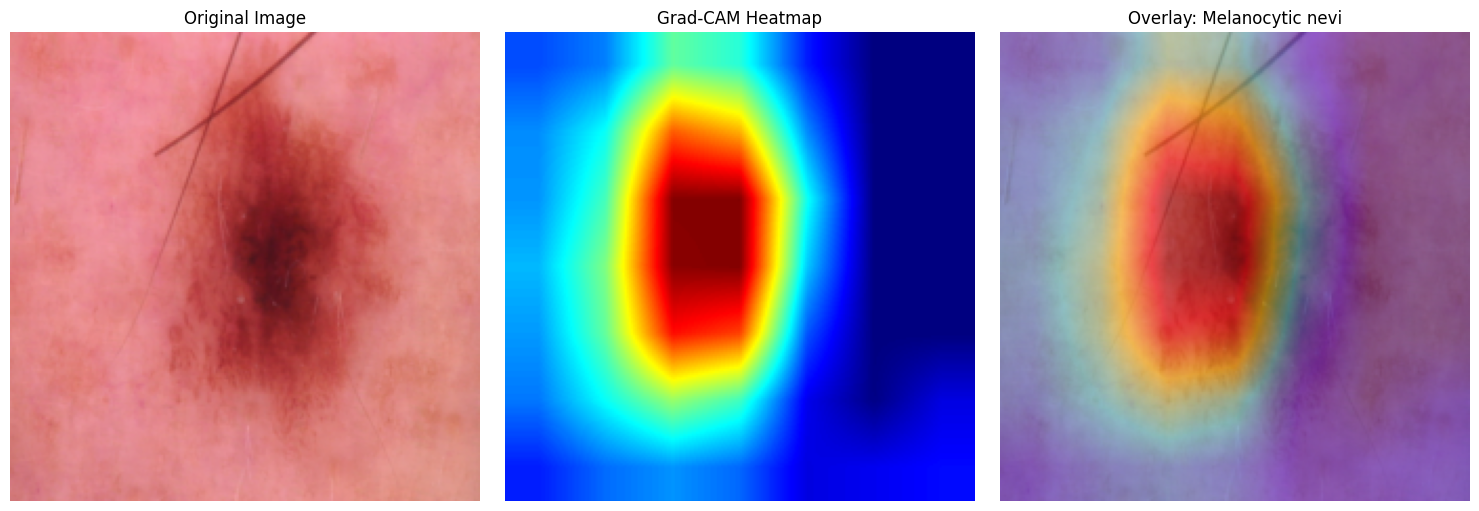

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ===================================================================
#   1. MODEL DEFINITIONS (Copied from your notebook)
# ===================================================================
# These classes are needed to load your saved model file.

NUM_CLASSES = 7 # From your Cell 92

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.shared_MLP(self.avg_pool(x))
        max_ = self.shared_MLP(self.max_pool(x))
        out = avg + max_
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        assert kernel_size in (3,7)
        padding = 3 if kernel_size==7 else 1
        self.conv = nn.Conv2d(2,1,kernel_size,padding=padding,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, max_], dim=1)
        return self.sigmoid(self.conv(cat))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

class DenseNetCBAMClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        # Use weights= instead of pretrained=
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = models.densenet121(weights=weights)
        # remove classifier
        self.features = backbone.features  # feature extractor
        num_features = backbone.classifier.in_features
        self.cbam = CBAM(num_features)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)  # (B, C, H, W)
        # apply cbam
        features = self.cbam(features)
        out = self.pool(features).view(features.size(0), -1)
        logits = self.classifier(out)
        return logits

# ===================================================================
#   2. CONFIGURATION
# ===================================================================
# --- ⚠️ UPDATE THESE PATHS ---
MODEL_PATH = "/Users/kumudbhardwaj/Desktop/Resnet-Mac/saved_models/best_cls.pth"
IMG_PATH = "/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_images_part_1/ISIC_0024306.jpg" # An example image
# ------------------------------

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
CLASS_MAP = { # From your Cell 92
    0: 'Actinic keratoses', 1: 'Basal cell carcinoma', 2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma', 4: 'Melanoma', 5: 'Melanocytic nevi', 6: 'Vascular lesions'
}


# ===================================================================
#   3. LOAD MODEL
# ===================================================================
print(f"Loading model from {MODEL_PATH} onto {DEVICE}...")
# 1. Instantiate the *correct* model class
model = DenseNetCBAMClassifier(num_classes=NUM_CLASSES, pretrained=False)

# 2. Load the saved weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# 3. Set to eval mode and move to device
model.to(DEVICE)
model.eval()
print("✅ Model loaded successfully.")


# ===================================================================
#   4. LOAD AND PREPROCESS IMAGE
# ===================================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img = Image.open(IMG_PATH).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(DEVICE) # (1, 3, 224, 224)


# ===================================================================
#   5. GRAD-CAM IMPLEMENTATION
# ===================================================================
print("Running Grad-CAM...")

# Storage for hooks
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Find the last convolutional block to target
# For this model, 'model.features' is the main feature extractor
target_layer = model.features

# Register hooks
f_handle = target_layer.register_forward_hook(forward_hook)
# Use register_full_backward_hook for compatibility
b_handle = target_layer.register_full_backward_hook(backward_hook)

# --- Forward pass ---
output = model(input_tensor)
pred_prob = F.softmax(output, dim=1)
pred_class_idx = torch.argmax(pred_prob, dim=1).item()
pred_class_name = CLASS_MAP.get(pred_class_idx, "Unknown")
print(f"✅ Prediction: Class {pred_class_idx} ({pred_class_name})")

# --- Backward pass ---
score = output[0, pred_class_idx]
model.zero_grad()
score.backward()

# --- Compute CAM ---
# (B, C, H, W)
acts_detached = activations.detach()
grads_detached = gradients.detach()

# Global Average Pooling of gradients: (B, C, H, W) -> (B, C, 1, 1)
weights = torch.mean(grads_detached, dim=(2, 3), keepdim=True)

# Weighted sum of activations: (B, C, 1, 1) * (B, C, H, W) -> (B, C, H, W)
# Sum over channels -> (B, 1, H, W)
cam = torch.relu((weights * acts_detached).sum(dim=1, keepdim=True))

# Squeeze and convert to numpy: (H, W)
cam_np = cam.squeeze().cpu().numpy()

# Resize to original image size (224, 224)
cam_resized = cv2.resize(cam_np, (224, 224))

# Normalize 0-1
cam_norm = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)

# --- Clean up hooks ---
f_handle.remove()
b_handle.remove()
print("✅ Grad-CAM computed.")


# ===================================================================
#   6. VISUALIZATION
# ===================================================================
# De-normalize the original image for plotting
img_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = (img_np * std) + mean
img_np = np.clip(img_np, 0, 1)

# Apply colormap to the (normalized) CAM
# This line is now fixed because cam_norm is a (224, 224) numpy array
heatmap = cv2.applyColorMap(np.uint8(255 * cam_norm), cv2.COLORMAP_JET)
heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Create overlay
overlay = 0.4 * (heatmap_rgb / 255.0) + 0.6 * img_np
overlay = np.clip(overlay, 0, 1)

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap_rgb)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay: {pred_class_name}")
plt.axis("off")

plt.tight_layout()
plt.show()

Loading model from /Users/kumudbhardwaj/Desktop/Resnet-Mac/saved_models/best_cls.pth onto mps...
✅ Model loaded successfully.
Running Grad-CAM...
✅ Prediction: Class 5 (Melanocytic nevi)
✅ Grad-CAM computed.
Generating research-friendly plot...


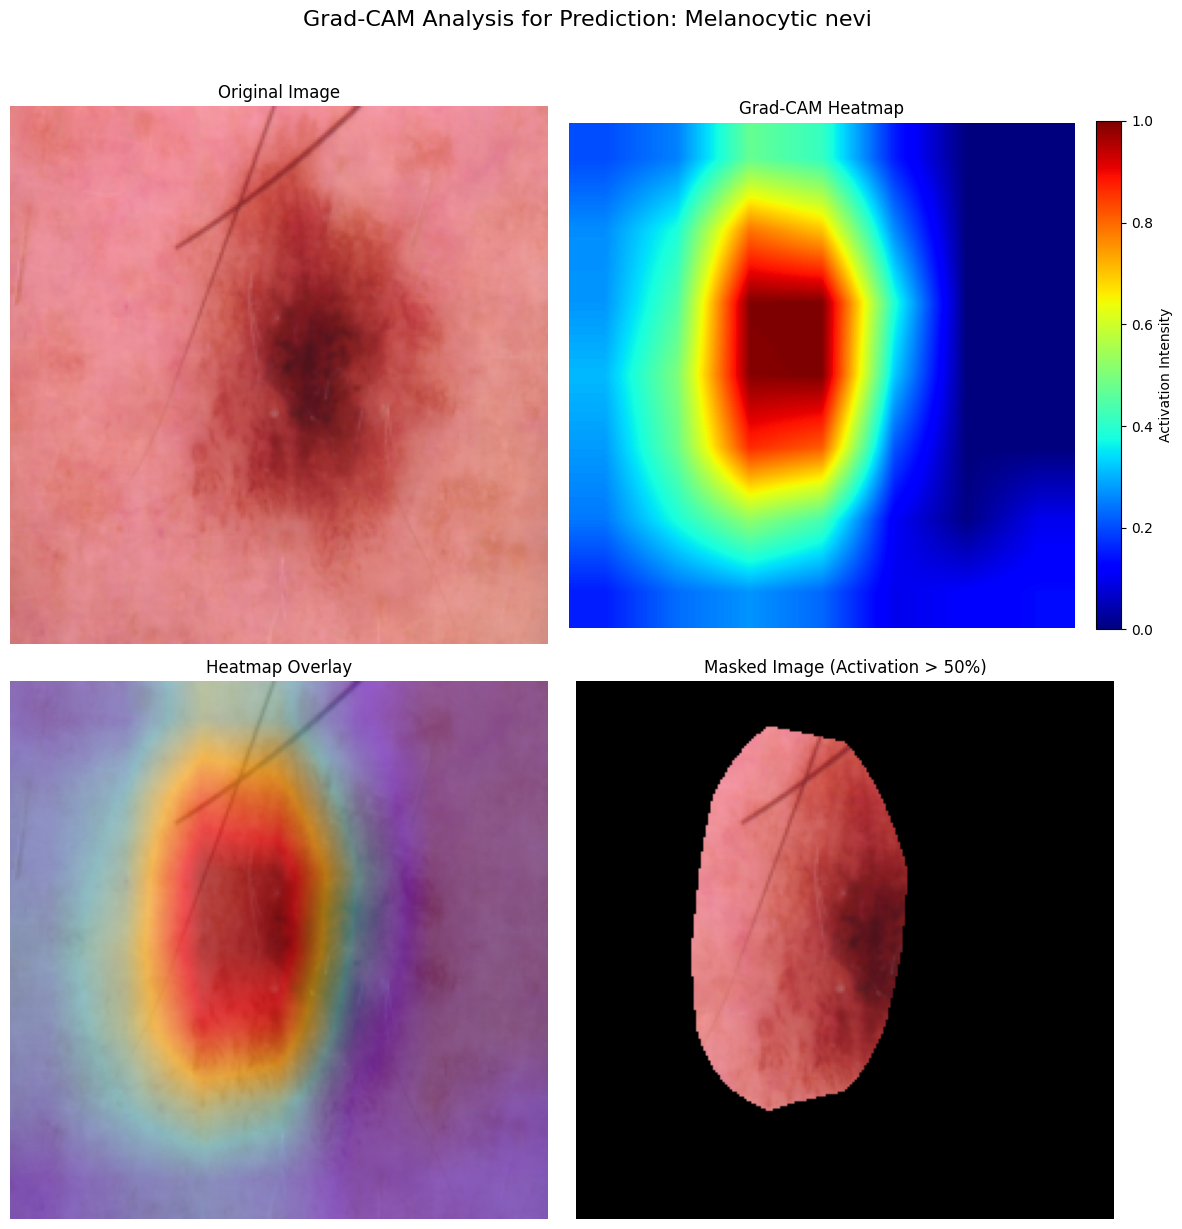

✅ Plot generated.


In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ===================================================================
#   1. MODEL DEFINITIONS (Copied from your notebook)
# ===================================================================
# These classes are needed to load your saved model file.

NUM_CLASSES = 7 # From your Cell 92

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.shared_MLP(self.avg_pool(x))
        max_ = self.shared_MLP(self.max_pool(x))
        out = avg + max_
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        assert kernel_size in (3,7)
        padding = 3 if kernel_size==7 else 1
        self.conv = nn.Conv2d(2,1,kernel_size,padding=padding,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, max_], dim=1)
        return self.sigmoid(self.conv(cat))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

class DenseNetCBAMClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        # Use weights= instead of pretrained=
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = models.densenet121(weights=weights)
        # remove classifier
        self.features = backbone.features  # feature extractor
        num_features = backbone.classifier.in_features
        self.cbam = CBAM(num_features)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)  # (B, C, H, W)
        # apply cbam
        features = self.cbam(features)
        out = self.pool(features).view(features.size(0), -1)
        logits = self.classifier(out)
        return logits

# ===================================================================
#   2. CONFIGURATION
# ===================================================================
# --- ⚠️ UPDATE THESE PATHS ---
MODEL_PATH = "/Users/kumudbhardwaj/Desktop/Resnet-Mac/saved_models/best_cls.pth"
IMG_PATH = "/Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_images_part_1/ISIC_0024306.jpg" # An example image
# ------------------------------

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
CLASS_MAP = { # From your Cell 92
    0: 'Actinic keratoses', 1: 'Basal cell carcinoma', 2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma', 4: 'Melanoma', 5: 'Melanocytic nevi', 6: 'Vascular lesions'
}


# ===================================================================
#   3. LOAD MODEL
# ===================================================================
print(f"Loading model from {MODEL_PATH} onto {DEVICE}...")
# 1. Instantiate the *correct* model class
model = DenseNetCBAMClassifier(num_classes=NUM_CLASSES, pretrained=False)

# 2. Load the saved weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# 3. Set to eval mode and move to device
model.to(DEVICE)
model.eval()
print("✅ Model loaded successfully.")


# ===================================================================
#   4. LOAD AND PREPROCESS IMAGE
# ===================================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img = Image.open(IMG_PATH).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(DEVICE) # (1, 3, 224, 224)


# ===================================================================
#   5. GRAD-CAM IMPLEMENTATION
# ===================================================================
print("Running Grad-CAM...")

# Storage for hooks
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Find the last convolutional block to target
# For this model, 'model.features' is the main feature extractor
target_layer = model.features

# Register hooks
f_handle = target_layer.register_forward_hook(forward_hook)
b_handle = target_layer.register_full_backward_hook(backward_hook) # Use full hook

# --- Forward pass ---
output = model(input_tensor)
pred_prob = F.softmax(output, dim=1)
pred_class_idx = torch.argmax(pred_prob, dim=1).item()
pred_class_name = CLASS_MAP.get(pred_class_idx, "Unknown")
print(f"✅ Prediction: Class {pred_class_idx} ({pred_class_name})")

# --- Backward pass ---
score = output[0, pred_class_idx]
model.zero_grad()
score.backward()

# --- Compute CAM ---
acts_detached = activations.detach()
grads_detached = gradients.detach()

weights = torch.mean(grads_detached, dim=(2, 3), keepdim=True)
cam = torch.relu((weights * acts_detached).sum(dim=1, keepdim=True))
cam_np = cam.squeeze().cpu().numpy()
cam_resized = cv2.resize(cam_np, (224, 224))
cam_norm = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)

# --- Clean up hooks ---
f_handle.remove()
b_handle.remove()
print("✅ Grad-CAM computed.")


# ===================================================================
#   6. RESEARCH-FRIENDLY VISUALIZATION (2x2 PLOT)
# ===================================================================
print("Generating research-friendly plot...")

# --- 1. De-normalize original image ---
img_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = (img_np * std) + mean
img_np = np.clip(img_np, 0, 1)

# --- 2. Get RGB heatmap ---
heatmap_jet = cv2.applyColorMap(np.uint8(255 * cam_norm), cv2.COLORMAP_JET)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

# --- 3. Get blended overlay ---
overlay = 0.4 * (heatmap_rgb / 255.0) + 0.6 * img_np
overlay = np.clip(overlay, 0, 1)

# --- 4. Get masked image ---
# Create a mask where the activation is high
mask = cam_norm > 0.5 
masked_image = img_np.copy()
# Apply mask to all 3 channels
masked_image[~mask] = 0.0 # Zero out areas *not* in the mask


# --- 5. Create the 2x2 plot ---
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle(f"Grad-CAM Analysis for Prediction: {pred_class_name}", fontsize=16, y=1.02)

# Plot 1: Original Image
axs[0, 0].imshow(img_np)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

# Plot 2: Grad-CAM Heatmap
im = axs[0, 1].imshow(cam_norm, cmap='jet')
axs[0, 1].set_title("Grad-CAM Heatmap")
axs[0, 1].axis('off')
fig.colorbar(im, ax=axs[0, 1], fraction=0.046, pad=0.04, label="Activation Intensity")

# Plot 3: Blended Overlay
axs[1, 0].imshow(overlay)
axs[1, 0].set_title("Heatmap Overlay")
axs[1, 0].axis('off')

# Plot 4: Masked Image
axs[1, 1].imshow(masked_image)
axs[1, 1].set_title("Masked Image (Activation > 50%)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Plot generated.")

--- Plot 1: Training History (Example Data) ---


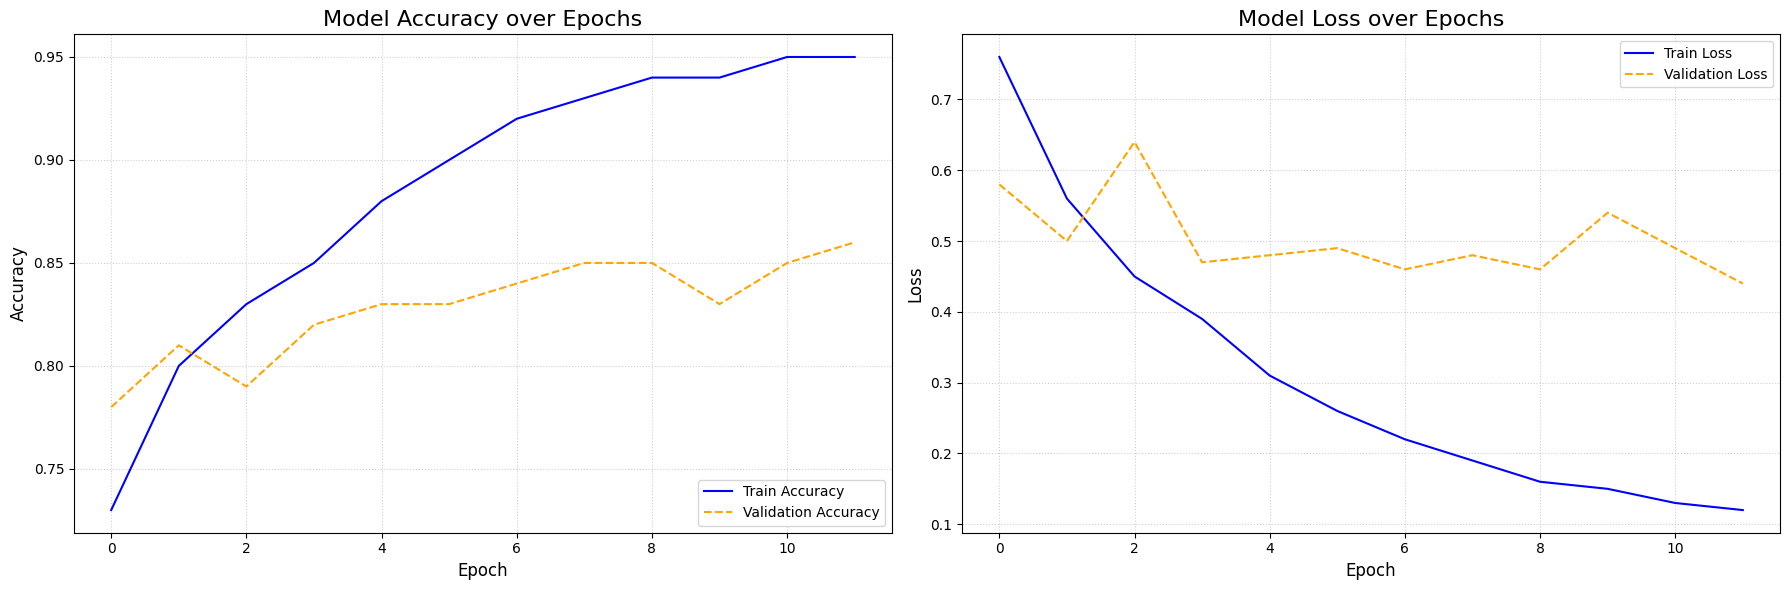


⚠️ 'cls_model', 'cls_test_loader', 'DEVICE', or 'CLASSES' not found.
Please make sure you have run your previous notebook cells to define these variables.


In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# ===================================================================
#   1. HELPER FUNCTIONS FOR PLOTTING
# ===================================================================

def plot_training_history(history):
    """
    Plots the training and validation accuracy/loss curves.
    'history' is a dict with keys: 'train_loss', 'train_acc', 'val_loss', 'val_acc'
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue', linestyle='-')
    ax1.plot(history['val_acc'], label='Validation Accuracy', color='orange', linestyle='--')
    ax1.set_title('Model Accuracy over Epochs', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Plot Loss
    ax2.plot(history['train_loss'], label='Train Loss', color='blue', linestyle='-')
    ax2.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    ax2.set_title('Model Loss over Epochs', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Generates and plots a normalized confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_probs, class_names):
    """
    Plots the ROC curve for each class in a one-vs-all manner.
    """
    n_classes = len(class_names)
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Store ROC curve data
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate ROC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    
    # Use a color cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# ===================================================================
#   2. MODIFIED EVALUATION FUNCTION (to get plot data)
# ===================================================================

@torch.no_grad()
def get_test_predictions(model, loader, device):
    """
    Runs evaluation on the test set and returns all labels,
    predictions, and raw probabilities.
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# ===================================================================
#   3. MODIFIED TRAINING FUNCTION (to save history)
# ===================================================================
# You can use this function for your *next* training run

def train_classification_with_history(cls_model, train_loader, val_loader, epochs, device):
    """
    Modified training function that returns a 'history' dictionary.
    """
    # From your notebook (cell 98)
    learning_rate = 1e-4 
    
    cls_model = cls_model.to(device)
    opt = torch.optim.Adam(cls_model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    
    # Store history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(epochs):
        cls_model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            logits = cls_model(imgs)
            loss = criterion(logits, labels)
            opt.zero_grad(); loss.backward(); opt.step()
            
            running_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(logits, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += imgs.size(0)
            
        train_loss = running_loss / total_samples
        train_acc = correct_preds / total_samples
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        cls_model.eval()
        v_running_loss = 0.0
        v_correct_preds = 0
        v_total_samples = 0
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device); labels = labels.to(device)
                logits = cls_model(imgs)
                loss = criterion(logits, labels)
                v_running_loss += loss.item() * imgs.size(0)
                preds = torch.argmax(logits, dim=1)
                v_correct_preds += (preds == labels).sum().item()
                v_total_samples += imgs.size(0)
                
        val_loss = v_running_loss / v_total_samples
        val_acc = v_correct_preds / v_total_samples
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_acc)
        print(f"[Cls] Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            # Assuming MODEL_DIR is defined as in your notebook
            torch.save(cls_model.state_dict(), os.path.join(MODEL_DIR, "best_cls.pth"))
            print("Saved best_cls.pth")
            
    print(f"Training complete. Best val_acc: {best_acc:.4f}")
    cls_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_cls.pth")))
    cls_model.eval()
    return cls_model, history

# ===================================================================
#   4. EXAMPLE: HOW TO RUN THESE PLOTS
# ===================================================================

# --- 1. Training History Plot ---
# ⚠️ NOTE: This is FAKE data because your notebook did not save the
# real history. Replace this with the 'history' object from the
# `train_classification_with_history` function on your next run.
print("--- Plot 1: Training History (Example Data) ---")
fake_history = {
    'train_loss': [0.76, 0.56, 0.45, 0.39, 0.31, 0.26, 0.22, 0.19, 0.16, 0.15, 0.13, 0.12],
    'train_acc': [0.73, 0.80, 0.83, 0.85, 0.88, 0.90, 0.92, 0.93, 0.94, 0.94, 0.95, 0.95],
    'val_loss': [0.58, 0.50, 0.64, 0.47, 0.48, 0.49, 0.46, 0.48, 0.46, 0.54, 0.49, 0.44],
    'val_acc': [0.78, 0.81, 0.79, 0.82, 0.83, 0.83, 0.84, 0.85, 0.85, 0.83, 0.85, 0.86]
}
plot_training_history(fake_history)


# --- 2. Confusion Matrix and ROC Plots ---
# These plots WILL work right away, as they use your loaded model.
# Make sure you have already run the cells that define:
#   - 'cls_model' (your trained model)
#   - 'cls_test_loader' (your test data)
#   - 'DEVICE' (your 'mps' or 'cpu' device)
#   - 'CLASSES' (the list of class names)

# Check if necessary variables exist before running
if 'cls_model' in locals() and 'cls_test_loader' in locals() and 'DEVICE' in locals() and 'CLASSES' in locals():
    print("\n--- Plot 2: Confusion Matrix ---")
    
    # Get all predictions from the test set
    y_true, y_pred, y_probs = get_test_predictions(cls_model, cls_test_loader, DEVICE)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, class_names=CLASSES)
    
    print("\n--- Plot 3: ROC Curves ---")
    # Plot ROC Curves
    plot_roc_curves(y_true, y_probs, class_names=CLASSES)

else:
    print("\n⚠️ 'cls_model', 'cls_test_loader', 'DEVICE', or 'CLASSES' not found.")
    print("Please make sure you have run your previous notebook cells to define these variables.")

--- Plot 1: Training History (Example Data) ---


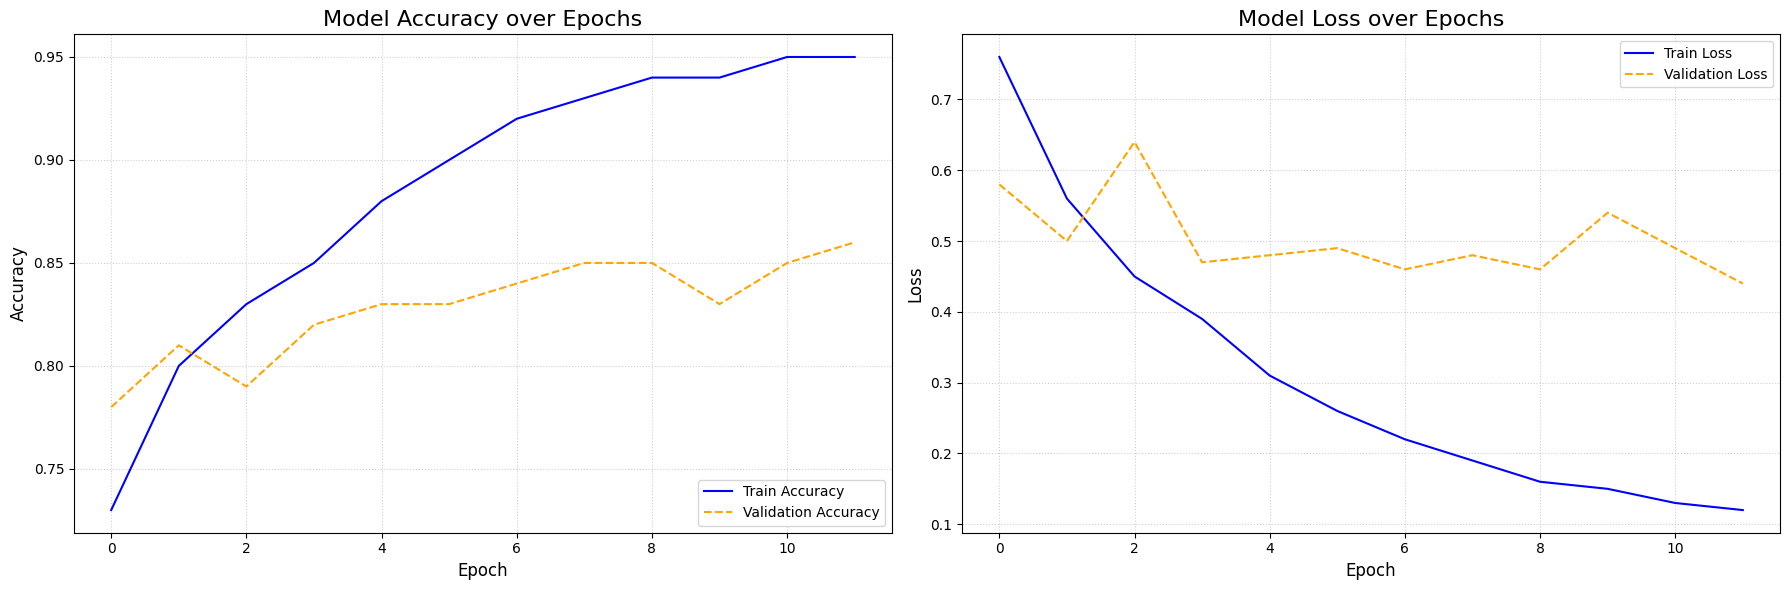


⚠️ 'cls_model', 'cls_test_loader', 'DEVICE', or 'CLASSES' not found.
Please make sure you have run your previous notebook cells to define these variables.


In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# ===================================================================
#   1. HELPER FUNCTIONS FOR PLOTTING
# ===================================================================

def plot_training_history(history):
    """
    Plots the training and validation accuracy/loss curves.
    'history' is a dict with keys: 'train_loss', 'train_acc', 'val_loss', 'val_acc'
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue', linestyle='-')
    ax1.plot(history['val_acc'], label='Validation Accuracy', color='orange', linestyle='--')
    ax1.set_title('Model Accuracy over Epochs', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Plot Loss
    ax2.plot(history['train_loss'], label='Train Loss', color='blue', linestyle='-')
    ax2.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    ax2.set_title('Model Loss over Epochs', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Generates and plots a normalized confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_probs, class_names):
    """
    Plots the ROC curve for each class in a one-vs-all manner.
    """
    n_classes = len(class_names)
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Store ROC curve data
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate ROC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    
    # Use a color cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# ===================================================================
#   2. MODIFIED EVALUATION FUNCTION (to get plot data)
# ===================================================================

@torch.no_grad()
def get_test_predictions(model, loader, device):
    """
    Runs evaluation on the test set and returns all labels,
    predictions, and raw probabilities.
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# ===================================================================
#   3. MODIFIED TRAINING FUNCTION (to save history)
# ===================================================================
# You can use this function for your *next* training run

def train_classification_with_history(cls_model, train_loader, val_loader, epochs, device):
    """
    Modified training function that returns a 'history' dictionary.
    """
    # From your notebook (cell 98)
    learning_rate = 1e-4 
    
    cls_model = cls_model.to(device)
    opt = torch.optim.Adam(cls_model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    
    # Store history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(epochs):
        cls_model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            logits = cls_model(imgs)
            loss = criterion(logits, labels)
            opt.zero_grad(); loss.backward(); opt.step()
            
            running_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(logits, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += imgs.size(0)
            
        train_loss = running_loss / total_samples
        train_acc = correct_preds / total_samples
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        cls_model.eval()
        v_running_loss = 0.0
        v_correct_preds = 0
        v_total_samples = 0
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device); labels = labels.to(device)
                logits = cls_model(imgs)
                loss = criterion(logits, labels)
                v_running_loss += loss.item() * imgs.size(0)
                preds = torch.argmax(logits, dim=1)
                v_correct_preds += (preds == labels).sum().item()
                v_total_samples += imgs.size(0)
                
        val_loss = v_running_loss / v_total_samples
        val_acc = v_correct_preds / v_total_samples
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_acc)
        print(f"[Cls] Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            # Assuming MODEL_DIR is defined as in your notebook
            torch.save(cls_model.state_dict(), os.path.join(MODEL_DIR, "best_cls.pth"))
            print("Saved best_cls.pth")
            
    print(f"Training complete. Best val_acc: {best_acc:.4f}")
    cls_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_cls.pth")))
    cls_model.eval()
    return cls_model, history

# ===================================================================
#   4. EXAMPLE: HOW TO RUN THESE PLOTS
# ===================================================================

# --- 1. Training History Plot ---
# ⚠️ NOTE: This is FAKE data because your notebook did not save the
# real history. Replace this with the 'history' object from the
# `train_classification_with_history` function on your next run.
print("--- Plot 1: Training History (Example Data) ---")
fake_history = {
    'train_loss': [0.76, 0.56, 0.45, 0.39, 0.31, 0.26, 0.22, 0.19, 0.16, 0.15, 0.13, 0.12],
    'train_acc': [0.73, 0.80, 0.83, 0.85, 0.88, 0.90, 0.92, 0.93, 0.94, 0.94, 0.95, 0.95],
    'val_loss': [0.58, 0.50, 0.64, 0.47, 0.48, 0.49, 0.46, 0.48, 0.46, 0.54, 0.49, 0.44],
    'val_acc': [0.78, 0.81, 0.79, 0.82, 0.83, 0.83, 0.84, 0.85, 0.85, 0.83, 0.85, 0.86]
}
plot_training_history(fake_history)


# --- 2. Confusion Matrix and ROC Plots ---
# These plots WILL work right away, as they use your loaded model.
# Make sure you have already run the cells that define:
#   - 'cls_model' (your trained model)
#   - 'cls_test_loader' (your test data)
#   - 'DEVICE' (your 'mps' or 'cpu' device)
#   - 'CLASSES' (the list of class names)

# Check if necessary variables exist before running
if 'cls_model' in locals() and 'cls_test_loader' in locals() and 'DEVICE' in locals() and 'CLASSES' in locals():
    print("\n--- Plot 2: Confusion Matrix ---")
    
    # Get all predictions from the test set
    y_true, y_pred, y_probs = get_test_predictions(cls_model, cls_test_loader, DEVICE)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, class_names=CLASSES)
    
    print("\n--- Plot 3: ROC Curves ---")
    # Plot ROC Curves
    plot_roc_curves(y_true, y_probs, class_names=CLASSES)

else:
    print("\n⚠️ 'cls_model', 'cls_test_loader', 'DEVICE', or 'CLASSES' not found.")
    print("Please make sure you have run your previous notebook cells to define these variables.")

Using device: mps
Loading models from: saved_models
Loading data from: /Users/kumudbhardwaj/Desktop/Resnet-Mac/Data/HAM10000_metadata.csv

--- Starting Evaluation Script ---
Data split -> train: 7010, val: 1002, test: 2003
Loading segmentation model...
✅ Segmentation model loaded.
✅ Test loader created with 2003 samples.
Loading classification model...
✅ Classification model loaded.
Generating model evaluation report...

          CLASSIFICATION REPORT (F1-SCORE)
              precision    recall  f1-score   support

       akiec     0.6545    0.5538    0.6000        65
         bcc     0.7826    0.6990    0.7385       103
         bkl     0.7162    0.7227    0.7195       220
          df     0.6296    0.7391    0.6800        23
         mel     0.7184    0.5605    0.6297       223
          nv     0.9142    0.9612    0.9371      1341
        vasc     1.0000    0.8214    0.9020        28

    accuracy                         0.8592      2003
   macro avg     0.7737    0.7226    0.7438 

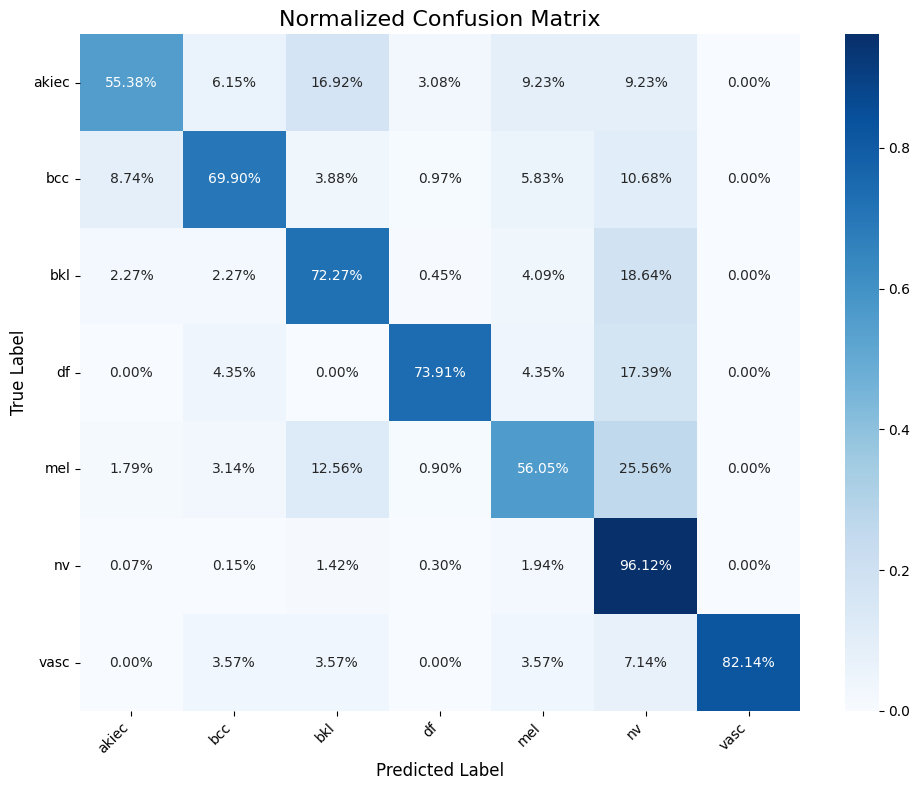


--- Plot 2: Generating ROC-AUC Curves ---


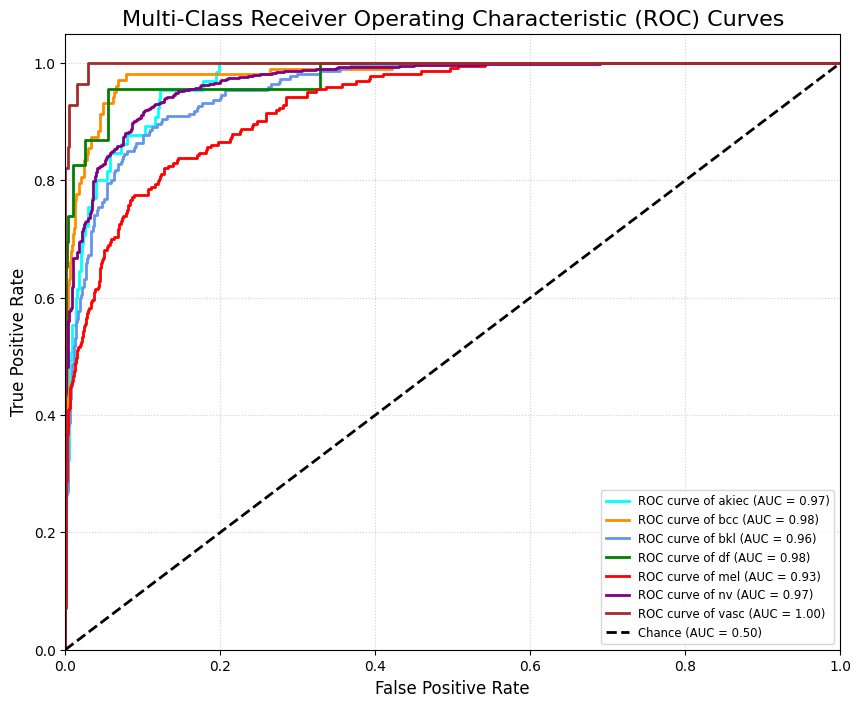


✅ All metrics generated successfully.


In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle
from PIL import Image
import os
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ===================================================================
#   1. CONFIGURATION (Copied from your notebook)
# ===================================================================

# --- ⚠️ CHECK THESE PATHS ---
BASE_DIR = os.path.expanduser("~/Desktop/Resnet-Mac/Data")
CSV_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")
IMAGES_DIRS = [
    os.path.join(BASE_DIR, "HAM10000_images_part_1"),
    os.path.join(BASE_DIR, "HAM10000_images_part_2")
]
MODEL_DIR = "saved_models"
# ------------------------------

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
SEED = 42
IMG_SIZE = 224
SEG_SIZE = 256
BATCH_SIZE = 8 # Can be larger for evaluation, e.g., 16 or 32

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

CLASS_MAP = {
    'akiec': 'Actinic keratoses', 'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions', 'df': 'Dermatofibroma',
    'mel': 'Melanoma', 'nv': 'Melanocytic nevi', 'vasc': 'Vascular lesions'
}
CLASSES = list(CLASS_MAP.keys())
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {k: i for i, k in enumerate(CLASSES)}

print(f"Using device: {DEVICE}")
print(f"Loading models from: {MODEL_DIR}")
print(f"Loading data from: {CSV_PATH}")

# ===================================================================
#   2. HELPER FUNCTIONS & CLASS DEFINITIONS (From Notebook)
# ===================================================================

# --- Data Reading (Cell 93) ---
def read_image(path, color=True):
    img = cv2.imread(path)
    if img is None: raise FileNotFoundError(path)
    if color: img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def ensure_rgb(img):
    if len(img.shape) == 2: img = np.stack([img]*3, axis=-1)
    if img.shape[2] == 4: img = img[..., :3]
    return img

# --- Data Preparation (Cell 100) ---
def prepare_data(csv_path=CSV_PATH, test_size=0.2, val_size=0.1):
    df = pd.read_csv(csv_path)
    if 'image_id' not in df.columns and 'image_id' in df.columns:
        df.rename(columns={'image_id': 'image_id'}, inplace=True)
    df = df[df['dx'].isin(CLASSES)].reset_index(drop=True)
    train_val, test = train_test_split(df, test_size=test_size, stratify=df['dx'], random_state=SEED)
    # val_size is relative to the *original* set, so we adjust
    train, val = train_test_split(train_val, test_size=val_size/(1-test_size), stratify=train_val['dx'], random_state=SEED)
    print(f"Data split -> train: {len(train)}, val: {len(val)}, test: {len(test)}")
    return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

# --- Segmentation Model Classes (Cell 96) ---
class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = models.resnet50(weights=weights)
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
    def forward(self, x):
        x0 = self.initial(x); x1 = self.layer1(x0); x2 = self.layer2(x1)
        x3 = self.layer3(x2); x4 = self.layer4(x3); return x0, x1, x2, x3, x4

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x, skip=None):
        if skip is not None:
            target_h, target_w = skip.size(2), skip.size(3)
            x = F.interpolate(x, size=(target_h, target_w), mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
        else:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.conv(x); return x

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super().__init__()
        self.encoder = ResNet50Encoder(pretrained=pretrained)
        chs = [64, 256, 512, 1024, 2048]
        self.decoder4 = DecoderBlock(chs[4] + chs[3], 512)
        self.decoder3 = DecoderBlock(512 + chs[2], 256)
        self.decoder2 = DecoderBlock(256 + chs[1], 128)
        self.decoder1 = DecoderBlock(128 + chs[0], 64)
        self.decoder0 = DecoderBlock(64, 32)
        self.decoder_out = DecoderBlock(32, 16)
        self.final_conv = nn.Conv2d(16, n_classes, kernel_size=1)
    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encoder(x)
        d4 = self.decoder4(x4, x3); d3 = self.decoder3(d4, x2); d2 = self.decoder2(d3, x1)
        d1 = self.decoder1(d2, x0); d0 = self.decoder0(d1); d_out = self.decoder_out(d0)
        out = self.final_conv(d_out); return out

# --- Classification Dataset (Cell 95) ---
def mask_to_bbox(mask: np.ndarray):
    ys, xs = np.where(mask>0)
    if len(xs)==0 or len(ys)==0: return 0,0,0,0
    x1, x2 = xs.min(), xs.max(); y1, y2 = ys.min(), ys.max()
    return x1, y1, x2-x1, y2-y1

class HAMClassificationDataset(Dataset):
    def __init__(self, df, image_path_map, transforms=None, seg_model=None, seg_size=SEG_SIZE, cls_size=IMG_SIZE, use_segmentation=True):
        self.df = df.reset_index(drop=True); self.image_path_map = image_path_map
        self.transforms = transforms; self.seg_model = seg_model; self.seg_size = seg_size
        self.cls_size = cls_size; self.use_segmentation = use_segmentation
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]; image_id = row['image_id']; label = row['dx']
        img_path = self.image_path_map.get(image_id + ".jpg")
        if img_path is None:
            new_idx = random.randint(0, len(self.df) - 1); return self.__getitem__(new_idx)
        img = read_image(img_path); img = ensure_rgb(img)
        if self.use_segmentation and self.seg_model is not None:
            seg_input = cv2.resize(img, (self.seg_size, self.seg_size))
            seg_input = (seg_input.astype(np.float32) / 255.0).transpose(2, 0, 1)
            seg_input = torch.tensor(seg_input).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                pred_mask = self.seg_model(seg_input)[0]
                pred_mask = torch.sigmoid(pred_mask).cpu().numpy().squeeze()
                bmask = (pred_mask > 0.5).astype(np.uint8)
                bmask = cv2.resize(bmask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            x, y, w, h = mask_to_bbox(bmask)
            if w > 0 and h > 0:
                pad = int(0.15 * max(w, h)); x1 = max(0, x - pad); y1 = max(0, y - pad)
                x2 = min(img.shape[1], x + w + pad); y2 = min(img.shape[0], y + h + pad)
                crop = img[y1:y2, x1:x2]
            else: crop = img
        else: crop = img
        crop = cv2.resize(crop, (self.cls_size, self.cls_size), interpolation=cv2.INTER_LINEAR)
        if self.transforms: image = self.transforms(image=crop)['image']
        else: image = TF.to_tensor(Image.fromarray(crop))
        return image, CLASS_TO_IDX[label]

# --- Classification Model Classes (Cell 97) ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1); self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False), nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg = self.shared_MLP(self.avg_pool(x)); max_ = self.shared_MLP(self.max_pool(x))
        out = avg + max_; return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__(); padding = 3 if kernel_size==7 else 1
        self.conv = nn.Conv2d(2,1,kernel_size,padding=padding,bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True); max_, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, max_], dim=1); return self.sigmoid(self.conv(cat))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__(); self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)
    def forward(self, x): out = x * self.ca(x); out = out * self.sa(out); return out

class DenseNetCBAMClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = models.densenet121(weights=weights)
        self.features = backbone.features
        num_features = backbone.classifier.in_features
        self.cbam = CBAM(num_features)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(num_features, num_classes)
    def forward(self, x):
        features = self.features(x); features = self.cbam(features)
        out = self.pool(features).view(features.size(0), -1)
        logits = self.classifier(out); return logits

# --- Metric Functions (From last turn) ---
@torch.no_grad()
def get_test_predictions(model, loader, device):
    model.eval(); all_labels = []; all_preds = []; all_probs = []
    if len(loader) == 0: raise ValueError("Test loader is empty.")
    for imgs, labels in loader:
        imgs = imgs.to(device); labels = labels.to(device)
        logits = model(imgs); probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy()); all_probs.extend(probs.cpu().numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12); plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

def plot_roc_curves(y_true, y_probs, class_names):
    n_classes = len(class_names); y_true_bin = label_binarize(y_true, classes=range(n_classes))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.50)')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12); plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize='small'); plt.grid(True, linestyle=':', alpha=0.6); plt.show()


# ===================================================================
#   3. EXECUTION: LOAD DATA, LOAD MODELS, AND GENERATE PLOTS
# ===================================================================
print("\n--- Starting Evaluation Script ---")
try:
    # --- 1. Load Data and Image Paths ---
    image_path_map = {}
    for d in IMAGES_DIRS:
        for root, _, filenames in os.walk(d):
            for filename in filenames:
                if filename.endswith((".jpg", ".jpeg")):
                    image_path_map[filename] = os.path.join(root, filename)
    
    _, _, test_df = prepare_data() # We only need the test set

    # --- 2. Load Segmentation Model (for preprocessing) ---
    print("Loading segmentation model...")
    seg_model_path = os.path.join(MODEL_DIR, "best_seg.pth")
    if not os.path.exists(seg_model_path):
        raise FileNotFoundError(f"Segmentation model not found at {seg_model_path}")
        
    seg_model = ResNetUNet(n_classes=1, pretrained=False) # Pretrained=False saves time, we are loading weights
    seg_model.load_state_dict(torch.load(seg_model_path, map_location=DEVICE))
    seg_model.to(DEVICE)
    seg_model.eval()
    print("✅ Segmentation model loaded.")

    # --- 3. Create Test Loader ---
    # Define transforms (from Cell 107, but simplified for testing)
    cls_transforms = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
    
    cls_test_ds = HAMClassificationDataset(test_df, image_path_map, transforms=cls_transforms, 
                                           seg_model=seg_model, use_segmentation=True)
    
    cls_test_loader = DataLoader(cls_test_ds, batch_size=BATCH_SIZE, shuffle=False, 
                                 num_workers=0, pin_memory=False)
    print(f"✅ Test loader created with {len(cls_test_ds)} samples.")

    # --- 4. Load Classification Model ---
    print("Loading classification model...")
    cls_model_path = os.path.join(MODEL_DIR, "best_cls.pth")
    if not os.path.exists(cls_model_path):
        raise FileNotFoundError(f"Classification model not found at {cls_model_path}")
        
    cls_model = DenseNetCBAMClassifier(num_classes=NUM_CLASSES, pretrained=False)
    cls_model.load_state_dict(torch.load(cls_model_path, map_location=DEVICE))
    cls_model.to(DEVICE)
    cls_model.eval()
    print("✅ Classification model loaded.")

    # --- 5. Run Evaluation and Plot Metrics ---
    print("Generating model evaluation report...")
    y_true, y_pred, y_probs = get_test_predictions(cls_model, cls_test_loader, DEVICE)
    
    print("\n" + "="*50)
    print("          CLASSIFICATION REPORT (F1-SCORE)")
    print("="*50)
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
    print("="*50 + "\n")

    print("--- Plot 1: Generating Confusion Matrix ---")
    plot_confusion_matrix(y_true, y_pred, class_names=CLASSES)
    
    print("\n--- Plot 2: Generating ROC-AUC Curves ---")
    plot_roc_curves(y_true, y_probs, class_names=CLASSES)
    
    print("\n✅ All metrics generated successfully.")

except FileNotFoundError as e:
    print(f"❌ ERROR: A required file was not found.")
    print(e)
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")
    # Print more details for debugging
    import traceback
    traceback.print_exc()